In [1]:
import os,sys
import glob
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation

from matplotlib.lines import Line2D
%matplotlib inline 
sns.set_style('darkgrid')

/home/jlk/Software/anaconda3/envs/Deepmetric/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# file path
dir_ = '/mnt/data1/jlk/Cmap_database/CLUE/'
cell_info_file = dir_ + "cellinfo_beta.txt"
gene_info_file = dir_ + 'geneinfo_beta.txt'
level5_info_file = dir_ + 'siginfo_beta.txt'
level3_info_file = dir_ + 'instinfo_beta.txt'
level3_save_dir = '{}/level3_cell_control'.format(dir_)
level4_save_dir = '{}/level4_cell_control'.format(dir_)
level5_save_dir = '{}/level5_cell_control'.format(dir_)

# use_cell_lines = ['MCF7','A375','PC3','HT29','A549','HA1E','NPC']
use_cell_lines = ['MCF7','A375','PC3','HT29','A549','HA1E']


In [3]:
##################
# cell demention data
##################

##### landmark gene
gene_df = pd.read_csv(gene_info_file,sep='\t')
print(gene_df['feature_space'].value_counts())
landmark_gene_df = gene_df[gene_df['feature_space']=='landmark']
landmark_gene_id = landmark_gene_df['gene_id']

##### cell info
level3_info_df = pd.read_csv(level3_info_file,sep='\t')
level3_info_df = level3_info_df[level3_info_df['pert_type'] == 'ctl_vehicle']
cell_types = level3_info_df['cell_iname'].value_counts()

def get_cell_data():
    y = []
    cell_type_label = 0
    for cell in use_cell_lines:
        cell_file = glob.glob('{}/{}*csv'.format(level3_save_dir,cell))[0]
        cell_df = pd.read_csv(cell_file)
        print(cell_file,cell_df.shape)

        cell_df = cell_df[cell_df['rid'].isin(landmark_gene_id)]
        cell_df = cell_df.sample(1000,axis=1,replace=True)
        
        cell_sig_data = cell_df.T.to_numpy()

        if cell_type_label == 0:
            all_cell_data = cell_sig_data
        else:
            all_cell_data = np.append(all_cell_data,cell_sig_data,axis=0)
        y += [cell]*cell_sig_data.shape[0]
        cell_type_label +=1
        print(cell_sig_data.shape,all_cell_data.shape,len(y))
    return all_cell_data,np.array(y)

cell_x,cell_y = get_cell_data()
X_tsne = TSNE(n_components=2, random_state=1).fit_transform(cell_x)
cell_demention_data = pd.DataFrame(X_tsne)
cell_demention_data.columns = ['x1','x2']
cell_demention_data['cell'] = cell_y

best inferred    9196
inferred         2154
landmark          978
Name: feature_space, dtype: int64


/home/jlk/Software/anaconda3/envs/Deepmetric/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


/mnt/data1/jlk/Cmap_database/CLUE//level3_cell_control/MCF7_10112.csv (12328, 10113)
(1000, 978) (1000, 978) 1000
/mnt/data1/jlk/Cmap_database/CLUE//level3_cell_control/A375_6997.csv (12328, 6998)
(1000, 978) (2000, 978) 2000
/mnt/data1/jlk/Cmap_database/CLUE//level3_cell_control/PC3_9178.csv (12328, 9179)
(1000, 978) (3000, 978) 3000
/mnt/data1/jlk/Cmap_database/CLUE//level3_cell_control/HT29_6595.csv (12328, 6596)
(1000, 978) (4000, 978) 4000
/mnt/data1/jlk/Cmap_database/CLUE//level3_cell_control/A549_8056.csv (12328, 8057)
(1000, 978) (5000, 978) 5000
/mnt/data1/jlk/Cmap_database/CLUE//level3_cell_control/HA1E_5551.csv (12328, 5552)
(1000, 978) (6000, 978) 6000


/home/jlk/Software/anaconda3/envs/Deepmetric/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jlk/Software/anaconda3/envs/Deepmetric/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [4]:
##################
# cell coralation
##################
# cell_dict = dict(zip(range(len(use_cell_lines)),use_cell_lines))
df = pd.DataFrame(cell_x)
cell_rep_df = df.groupby(cell_y).mean()
cell_rep_df.index = use_cell_lines
cor_df = spearmanr(cell_rep_df.T)[0]
cor_df = pd.DataFrame(cor_df)
cor_df.index = use_cell_lines
cor_df.columns = use_cell_lines

In [5]:
##################
# cell accuacy data
##################

data_file = 'experiment_result_dropout.xlsx'
df = pd.read_excel(data_file,sheet_name='cell_lines',index_col=0)
df['MOASL'] = df['MOAEMB']
df['SigMat'] = df['SVM']
df['Euclidean'] = df['euclidean']
df['L1000CDS'] = df['cosine']
df['Jaccard'] = df['jaccard']
df['Random'] = df['random']

methods = ['MOASL','DrSim','SigMat','RF',
           'GSEA','ssCmap','Xcosine','Xsum',
           'Euclidean','L1000CDS','Jaccard','Random']
# methods_belong = {'MOASL':'MOASL','DrSim':'Machine learning','SigMat':'Machine learning','RF':'Machine learning',
#            'GSEA':'Biology','ssCmap':'Biology','Xcosine':'Biology','Xsum':'Biology',
#            'Euclidean':'Distance','L1000CDS':'Distance','Jaccard':'Distance','Random':'Random'}

methods_belong = {'MOASL':'MOASL',
                  'DrSim':'Machine learning based','SigMat':'Machine learning based','RF':'Machine learning based',
                  'GSEA':'Statistics-based','ssCmap':'Statistics-based',
                  'Xcosine':'Statistics-based','Xsum':'Statistics-based',
                  'Euclidean':'Distance-based','L1000CDS':'Distance-based',
                  'Jaccard':'Distance-based','Random':'Random'}

cols = []
cols_kind = ['MOASL','Machine learning based','Statistics-based','Distance-based','Random']
col_pal = sns.color_palette("colorblind")
col_pal = sns.color_palette("deep", 10)
for method in methods:
    for i in range(len(cols_kind)):
        color = col_pal[i]
        kind = cols_kind[i]
        if methods_belong[method] == kind:
            cols.append(color)

df = df.loc[use_cell_lines]
print(df,df.index)
cells = []
acc_sig = []
acc_val = []
tests = []
labels = []
folds = []
kinds = []
for method in methods:
    for fold in [0,1,2]:
        for cell in use_cell_lines:
            df_cell = df.loc[cell]
            acc = df_cell[df_cell['Fold']==fold][method].values[0]
#             print(fold,acc,cell)
            acc_sig.append(acc)
            Test = df_cell[df_cell['Fold']==fold]['Test_sig'].values[0]
            tests.append(Test)
            acc_val.append(acc/Test)
            labels.append(method)
            folds.append(fold)
            kinds.append(methods_belong[method])
            cells.append(cell)
plot_df = pd.DataFrame()
# plot_df['test'] = tests
plot_df['method'] = labels
# plot_df['fold'] = folds
# plot_df['correct signatures'] = acc_sig
plot_df['accuracy'] = acc_val
plot_df['kind'] = kinds
plot_df['cell'] = cells
print(plot_df)
# plot_df= plot_df[plot_df['cell']=='MCF7']

      Fold  Train_sig  Test_sig  Train_drug  Test_drug  MOAEMB       per  \
MCF7     0       3449      1300         195         93     779  0.599231   
MCF7     1       3118      1613         187        101     983  0.609423   
MCF7     2       2931      1818         194         94    1185  0.651815   
A375     0       1916       963         165         92     450  0.467290   
A375     1       2067       812         178         79     350  0.431034   
A375     2       1775      1104         171         86     507  0.459239   
PC3      0       2798      1025         189         83     573  0.559024   
PC3      1       2627      1196         178         94     654  0.546823   
PC3      2       2221      1602         177         95     968  0.604245   
HT29     0       1224       587          94         52     325  0.553663   
HT29     1       1306       505         101         45     306  0.605941   
HT29     2       1092       719          97         49     425  0.591099   
A549     0  

In [6]:
from scipy import stats
# moasl = plot_df[plot_df['method']=='MOASL']['accuracy']
# ml = plot_df[plot_df['kind']=='Machine learning']['accuracy']
# bio = plot_df[plot_df['kind']=='Biology']['accuracy']
# dis = plot_df[plot_df['kind']=='Distance']['accuracy']


moasl = plot_df[plot_df['method']=='MOASL']['accuracy']
ml = plot_df[plot_df['kind']=='Machine learning based']['accuracy']
bio = plot_df[plot_df['kind']=='Statistics-based']['accuracy']
dis = plot_df[plot_df['kind']=='Distance-based']['accuracy']


def t_test(x1,x2):
    t,p = stats.ttest_ind(x1,x2)
    if p < 0.05 and p >0.01:
        label = '*'
    elif p < 0.01 and p > 0.001:
        label = '**'
    elif p < 0.001 and p > 0.0001:
        label = '***'
    elif p < 0.0001:
        label = '****'
    else:
        label = 'ns'
    print(p,label,np.mean(x1),np.mean(x2))
    return label,p

one,one_p = t_test(moasl,ml)
two,two_p = t_test(moasl,bio)
three,three_p = t_test(moasl,dis)

0.016225250734433993 * 0.5607966344974467 0.5165862921230211
1.3586489981349098e-06 **** 0.5607966344974467 0.4546091639423114
5.220765556334719e-06 **** 0.5607966344974467 0.46943149124666167


/home/jlk/Software/anaconda3/envs/Deepmetric/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  


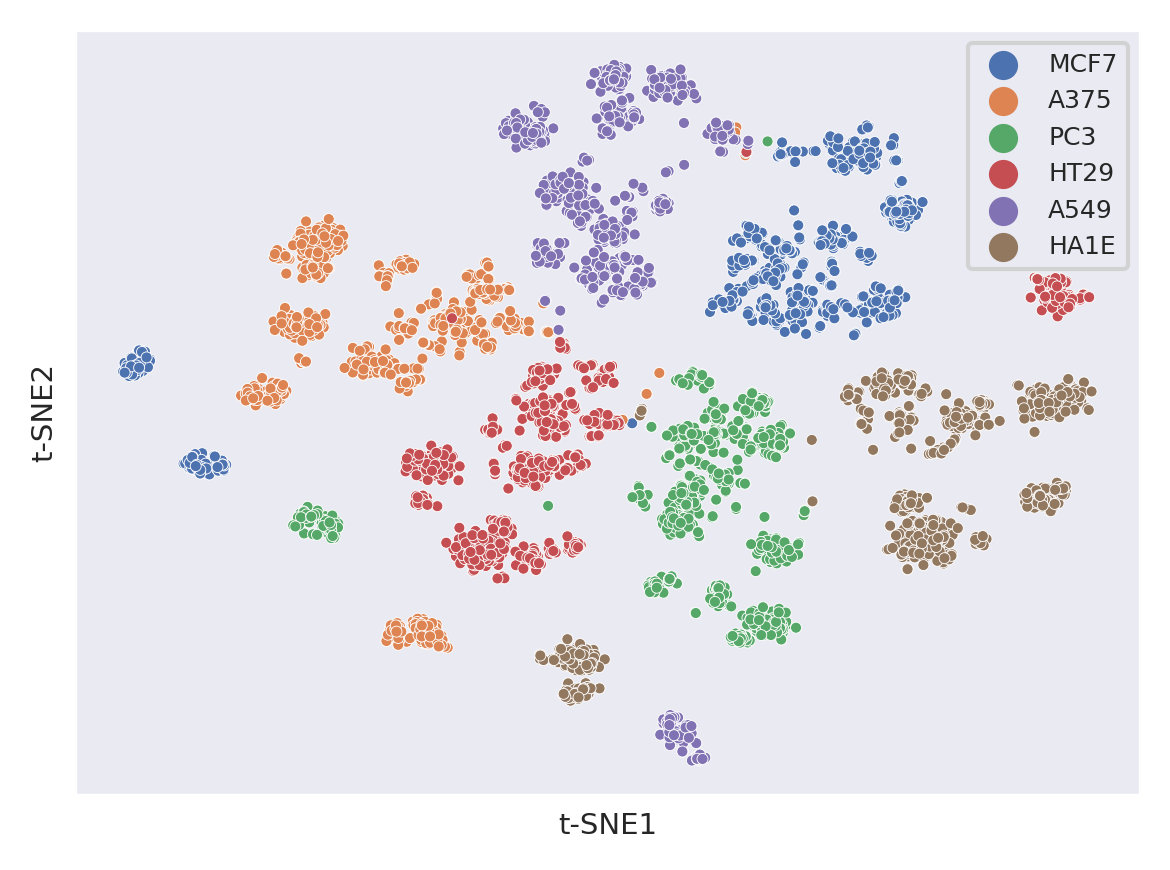

In [7]:
my_dpi=300
plt.figure(figsize=(4,3),dpi=my_dpi)

##################
# cell demention
ax1 = plt.subplot(1,1,1)
sns.scatterplot(data=cell_demention_data,x='x1',y='x2',hue='cell',
                palette=sns.color_palette("deep", 10),ax=ax1,s=7)
# plt.legend(bbox_to_anchor=(1.3, 0.5), loc='center left',fontsize=6)
plt.legend(fontsize=6)
# plt.title('A',loc='left')

plt.xticks([],[])
plt.yticks([],[])
plt.xlabel('t-SNE1',fontsize=7)
plt.ylabel('t-SNE2',fontsize=7)

plt.tight_layout()
# plt.show()
plt.savefig('Figure3_9.jpg')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

MOASL v.s. SigMat: t-test independent samples, P_val=6.443e-02 stat=1.911e+00
MOASL v.s. Xcosine: t-test independent samples, P_val=7.096e-04 stat=3.724e+00
MOASL v.s. L1000CDS: t-test independent samples, P_val=6.590e-04 stat=3.750e+00


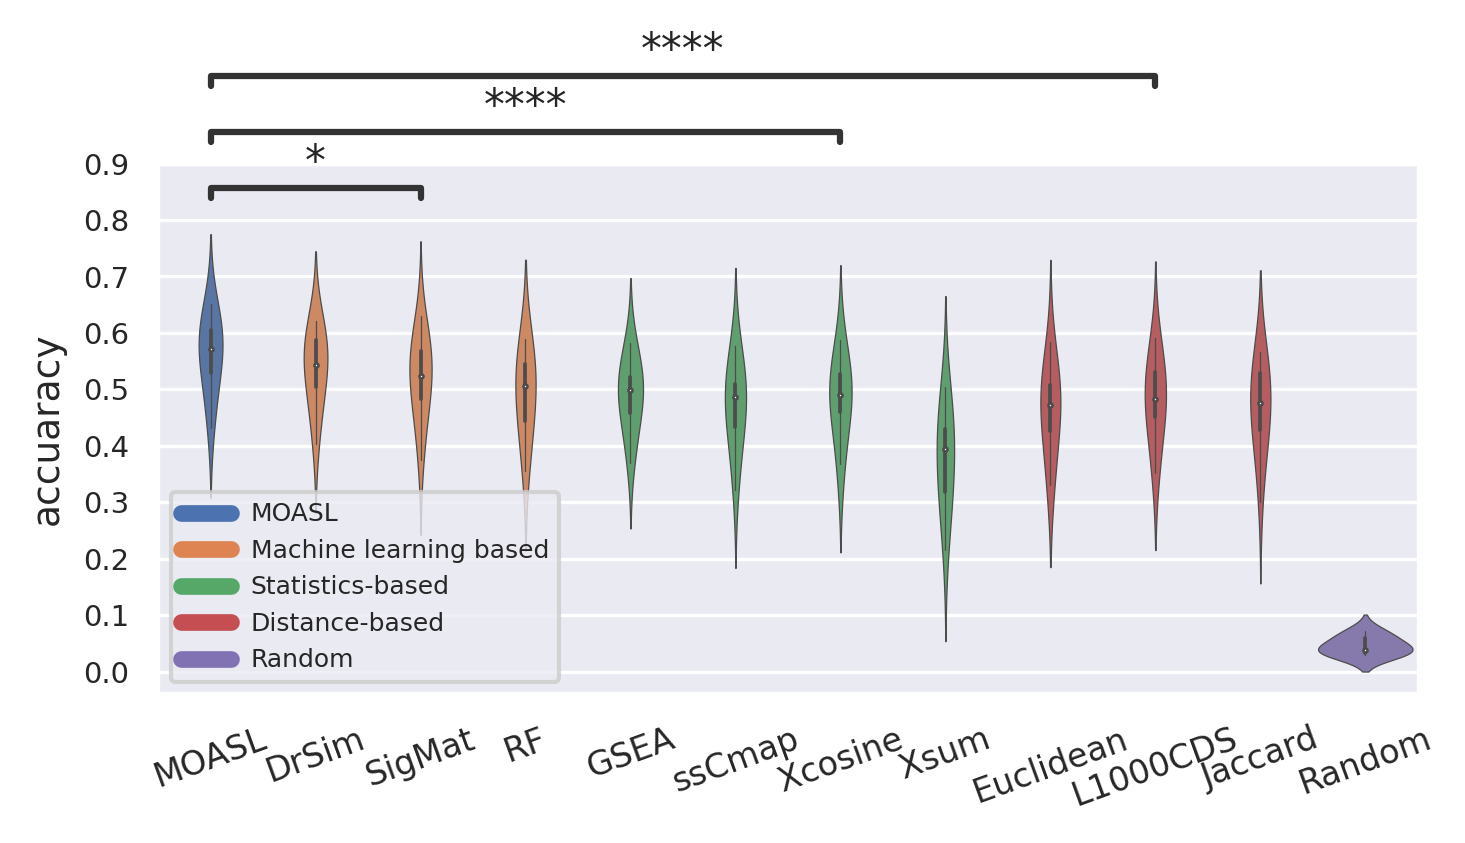

In [8]:
my_dpi=300
plt.figure(figsize=(5,3),dpi=my_dpi)

##################
# accuracy
ax3 = plt.subplot(1,1,1)
sns.violinplot(plot_df,x='method',y='accuracy',
               palette=cols,ax=ax3,bw=1,width=0.9,linewidth=.3).set(xlabel=None)

test_results = add_stat_annotation(ax3,data=plot_df,x='method',y='accuracy',order=methods,
                                  box_pairs=[("MOASL", "SigMat"),
                                             ('MOASL','Xcosine'),
                                             ("MOASL", "L1000CDS")],
                                    text_annot_custom=[one, two, three],
                                   test='t-test_ind', comparisons_correction=None, 
                                   text_format='star', loc='outside', verbose=2)

custom_lines = [Line2D([0], [0], color=col_pal[0], lw=4),
                Line2D([0], [0], color=col_pal[1], lw=4),
                Line2D([0], [0], color=col_pal[2], lw=4),
                Line2D([0], [0], color=col_pal[3], lw=4),
                Line2D([0], [0], color=col_pal[4], lw=4)]
ax3.legend(custom_lines, cols_kind,bbox_to_anchor=(0, 0.2), loc='center left',fontsize=6)
# plt.title('B',loc='left')
plt.xticks(rotation=20,fontsize=8)
plt.yticks([0,.1,.2,.3,.4,.5,.6,.7,.8,.9],fontsize=7)
plt.ylabel('accuaracy',fontsize=9)

plt.tight_layout()
# plt.show()
plt.savefig('Figure3_10.jpg')

/home/jlk/Software/anaconda3/envs/Deepmetric/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

MOASL v.s. SigMat: t-test independent samples, P_val=6.443e-02 stat=1.911e+00
MOASL v.s. Xcosine: t-test independent samples, P_val=7.096e-04 stat=3.724e+00
MOASL v.s. L1000CDS: t-test independent samples, P_val=6.590e-04 stat=3.750e+00


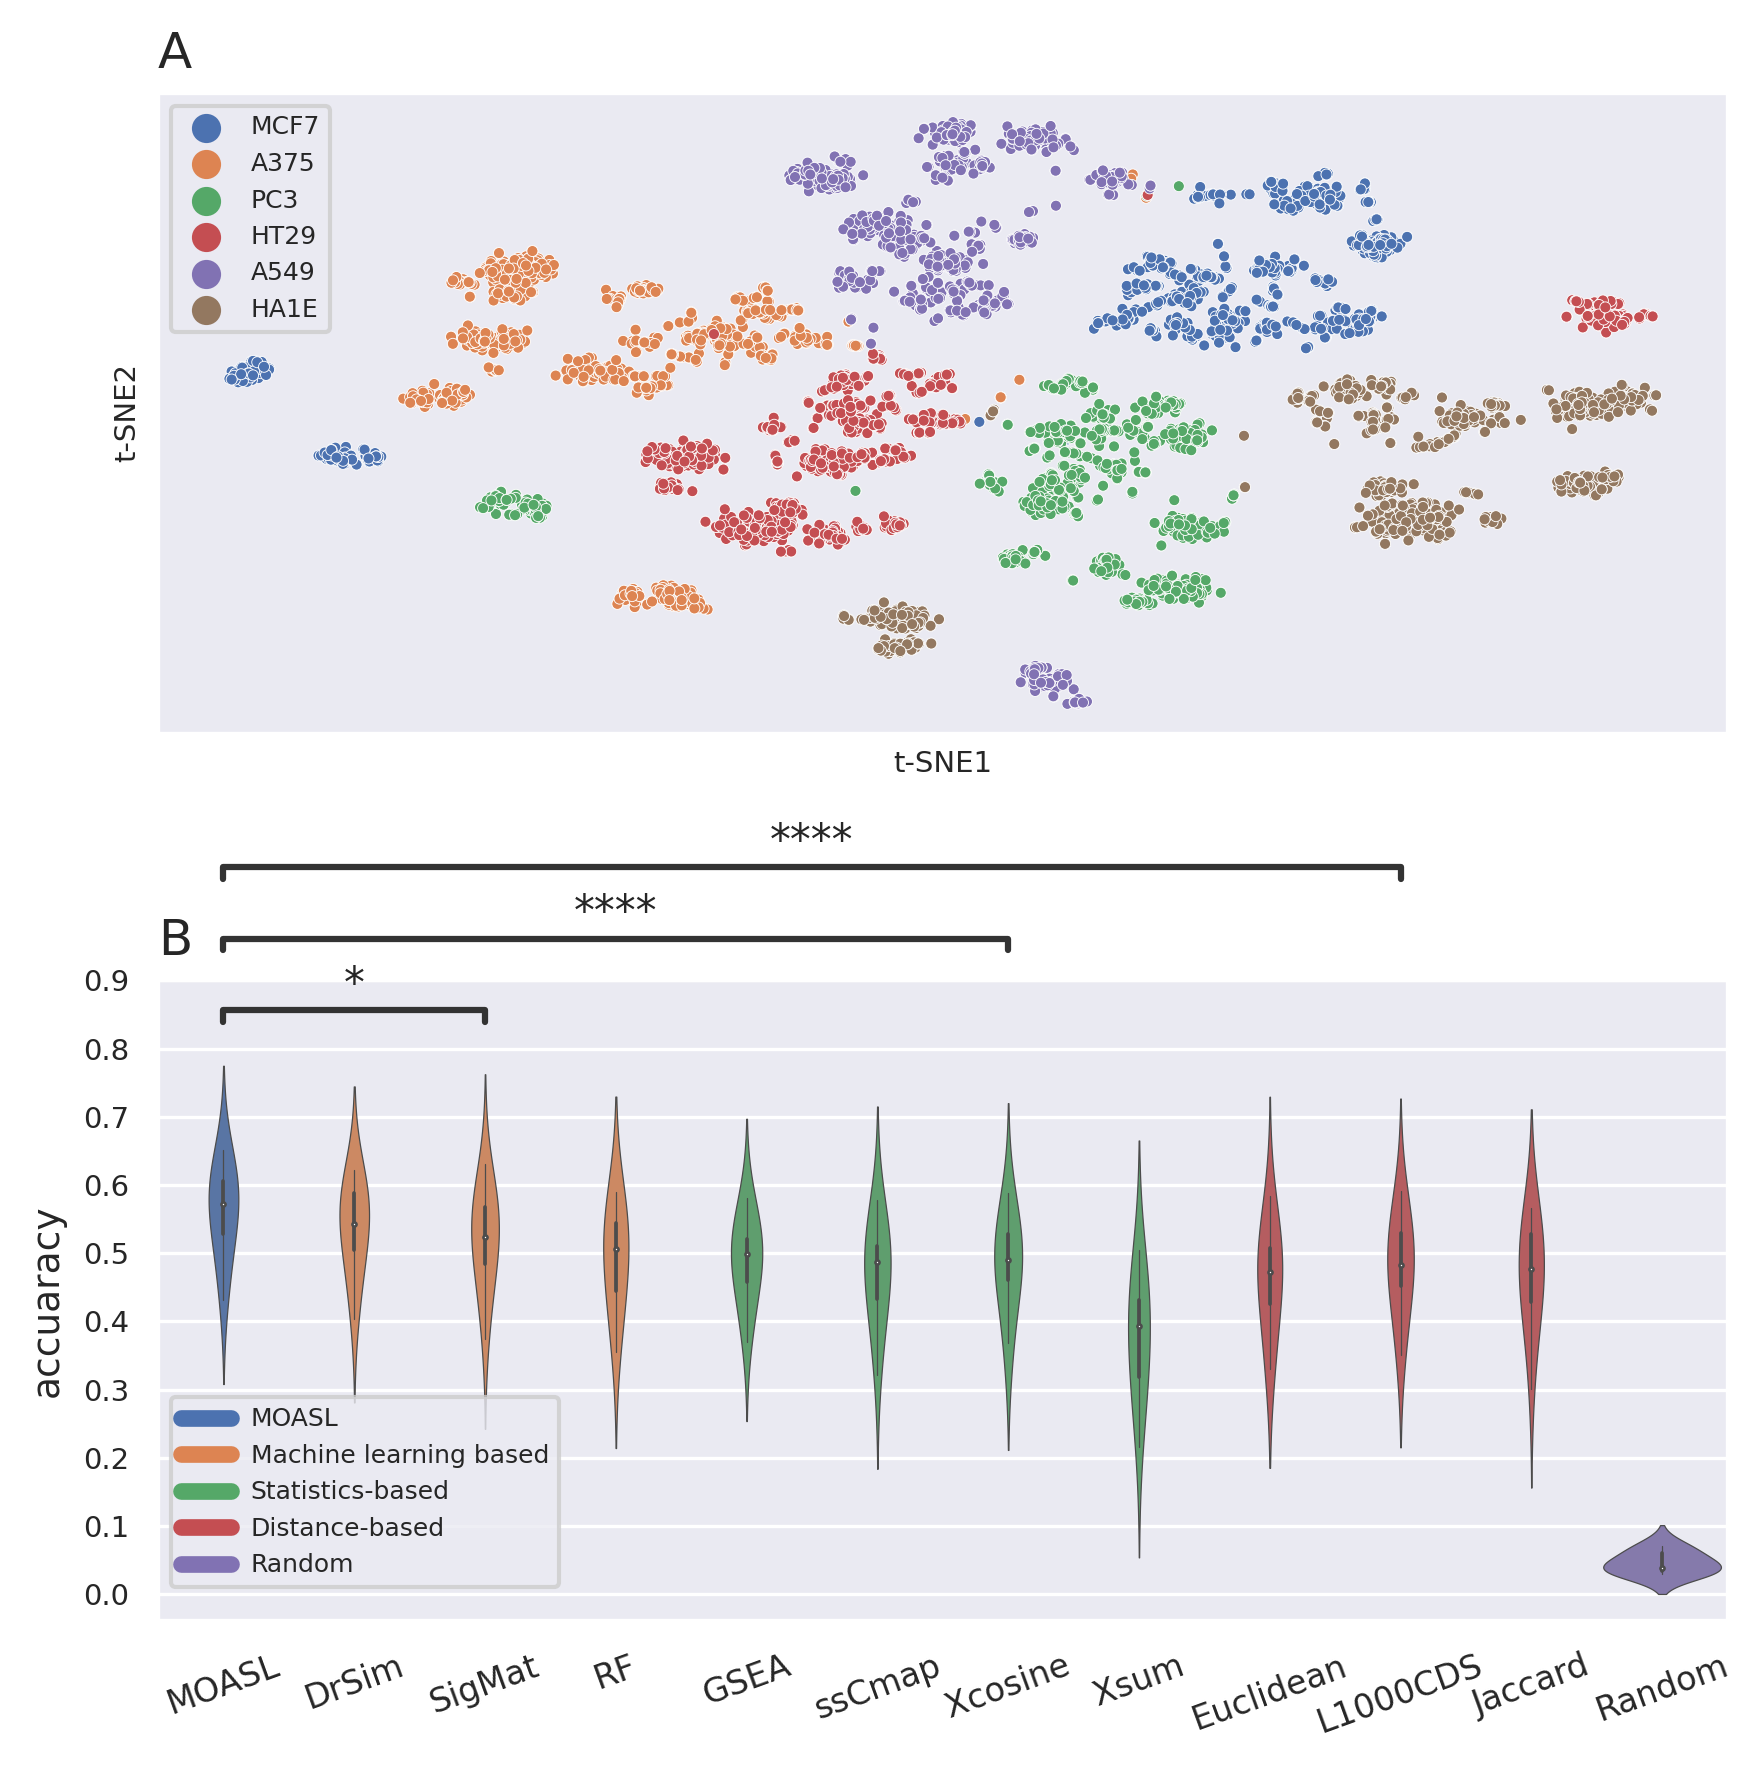

In [10]:
my_dpi=300
plt.figure(figsize=(6,6),dpi=my_dpi)

##################
# cell demention
ax1 = plt.subplot(2,1,1)
sns.scatterplot(data=cell_demention_data,x='x1',y='x2',hue='cell',
                palette=sns.color_palette("deep", 10),ax=ax1,s=7)
# plt.legend(bbox_to_anchor=(1.3, 0.5), loc='center left',fontsize=6)
plt.legend(fontsize=6)
plt.title('A',loc='left')

plt.xticks([],[])
plt.yticks([],[])
plt.xlabel('t-SNE1',fontsize=7)
plt.ylabel('t-SNE2',fontsize=7)

##################
# cell distance
# ax2 = plt.subplot(2,3,3)
# cmap="YlGnBu"
# cmap = sns.cubehelix_palette(start = 1.5, rot = 3, gamma=0.8, as_cmap = True)
# cmap="YlGn"

# cor_df=pd.read_csv('cor_df.csv',index_col=0)
# print(cor_df)
# sns.heatmap(cor_df,cmap=cmap,ax=ax2,)
# cbar = ax2.collections[0].colorbar
# cbar.ax.tick_params(labelsize=6)
# # cor_df.to_csv('cor_df.csv')
# plt.title('B',loc='left')
# plt.xticks(fontsize=6)
# plt.yticks(fontsize=6)

##################
# accuracy
ax3 = plt.subplot(2,1,2)
sns.violinplot(plot_df,x='method',y='accuracy',
               palette=cols,ax=ax3,bw=1,width=0.9,linewidth=.3).set(xlabel=None)

test_results = add_stat_annotation(ax3,data=plot_df,x='method',y='accuracy',order=methods,
                                  box_pairs=[("MOASL", "SigMat"),
                                             ('MOASL','Xcosine'),
                                             ("MOASL", "L1000CDS")],
                                    text_annot_custom=[one, two, three],
                                   test='t-test_ind', comparisons_correction=None, 
                                   text_format='star', loc='outside', verbose=2)

custom_lines = [Line2D([0], [0], color=col_pal[0], lw=4),
                Line2D([0], [0], color=col_pal[1], lw=4),
                Line2D([0], [0], color=col_pal[2], lw=4),
                Line2D([0], [0], color=col_pal[3], lw=4),
                Line2D([0], [0], color=col_pal[4], lw=4)]
ax3.legend(custom_lines, cols_kind,bbox_to_anchor=(0, 0.2), loc='center left',fontsize=6)
plt.title('B',loc='left')
plt.xticks(rotation=20,fontsize=8)
plt.yticks([0,.1,.2,.3,.4,.5,.6,.7,.8,.9],fontsize=7)
plt.ylabel('accuaracy',fontsize=9)

plt.tight_layout()
# plt.show()
plt.savefig('Figure5.jpg')